<a href="https://colab.research.google.com/github/secoxx/IE423/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
pip install plotly==5.23.0

In [40]:
pip install ucimlrepo

In [41]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import scale,label_binarize
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [42]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
dataset = fetch_ucirepo(id=468)

# data (as pandas dataframes)
X = dataset.data.features
y = dataset.data.targets

df = pd.concat([X, y], axis=1)
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# EDA

In [43]:
fig = px.histogram(df,x='Revenue',color='Revenue')
fig.update_layout(
    title="Histogram of Revenue",
    xaxis_title="Revenue",
    yaxis_title="Count",
)
fig.show()
print('Percentage of false:', len(df[df['Revenue']==False])/len(df)*100)
print('Percentage of true:', len(df[df['Revenue']==True])/len(df)*100)

Percentage of false: 84.52554744525548
Percentage of true: 15.474452554744525


The dataset is unbalanced as 15% of the dataset consists of purchases while 85% consists of no purchase.

In [44]:
df['Month'].unique()

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

In [45]:
category_orders = {
    'Month': ['Feb','Mar','May','June','Jul','Aug','Sep','Oct','Nov','Dec']
}
fig = px.histogram(df, x="Month", color="Revenue",category_orders=category_orders)
fig.show()

There is no data for months January and April. Additionally, we see that there are a lot more purchases in months may, november, march and december compared to other months. Let's see if there's a correlation between special days and the months were purchase levels are high.

In [46]:
category_orders = {
    'Month': ['Feb','Mar','May','June','Jul','Aug','Sep','Oct','Nov','Dec']
}
fig = px.histogram(df, x="Month", color="SpecialDay",category_orders=category_orders)
fig.show()

It looks like there's a correlation between the month of may's high purchase levels and special days in may. Same goes for february as well. However we don't see the same correlation with november and december, even though we expect to. This may be related to the way SpecialDay is calculated. In the documentation it says:"For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.". Therefore, if people buy presents early on for christmas, this dataset wouldn't accentuate that accurately; which might be the case. Overall, we can say that there's a correlation at least for may.

In [47]:
# labels = df['Vendor'].value_counts().index
# values = df['Vendor'].value_counts().values

fig = make_subplots(rows=3,
                    cols=2,
                    subplot_titles=['Operating Systems','Browser','Region','Traffic Type','Visitor Type','Weekend'])

fig.add_trace(
    go.Histogram(x=df['OperatingSystems']),
    1,
    1
)

fig.add_trace(
    go.Histogram(x=df['Browser']),
    1,
    2
)

fig.add_trace(
    go.Histogram(x=df['Region']),
    2,
    1
)

fig.add_trace(
    go.Histogram(x=df['TrafficType']),
    2,
    2
)

fig.add_trace(
    go.Histogram(x=df['VisitorType']),
    3,
    1
)

fig.add_trace(
    go.Histogram(x=df['Weekend']),
    3,
    2
)
fig.update_xaxes(tickvals=df['OperatingSystems'].unique(), ticktext=df['OperatingSystems'].unique(), row=1, col=1)
fig.update_xaxes(tickvals=df['Browser'].unique(), ticktext=df['Browser'].unique(), row=1, col=2)
fig.update_xaxes(tickvals=df['Region'].unique(), ticktext=df['Region'].unique(), row=2, col=1)
fig.update_xaxes(tickvals=df['TrafficType'].unique(), ticktext=df['TrafficType'].unique(), row=2, col=2)
fig.update_xaxes(tickvals=df['VisitorType'].unique(), ticktext=df['VisitorType'].unique(), row=3, col=1)
fig.update_xaxes(tickvals=df['Weekend'].unique(), ticktext=df['Weekend'].unique(), row=3, col=2)

fig.update_layout(height=1200, width=1000, title_text="Side By Side Subplots")
fig.show()

We see that most visitors were returning visitors and they visited the page mostly on weekdays.

In [48]:
fig = px.scatter(df, x="ProductRelated", y="ProductRelated_Duration", facet_col="Revenue",trendline='ols')
fig.show()

In [49]:
fig = px.histogram(df, x="Informational", y="Informational_Duration", facet_col="Revenue",histfunc='avg')
fig.show()

We see that visitors who purchase and don't purchase on average spend similar time on informational pages while some visitors who don't purchase look at a lot of informational pages as well as spending a lot of time on them.

In [50]:
fig = px.histogram(df, x="Administrative", y="Administrative_Duration", facet_col="Revenue",histfunc='avg')
fig.show()

We see the same mirroring effect of visitors who do and don't purchase in Administrative pages as well. It looks like there is not much correlation between purchase behavior and the amount of time the visitor spends on Informational and Administrative pages.

In [51]:
fig = px.scatter(df, x="BounceRates", y="ExitRates", facet_col="Revenue",trendline='ols')
fig.show()

Bounce rates and exit rates seem to be positively correlated.

In [52]:
fig = px.box(df,y='PageValues',x='Revenue')
fig.show()

It looks like people who have made a purchase tend to have higher PageValues.

# Preprocessing
We're going to do label encoding on categorical variables and we're going to scale the features. We have no missing values.

In [53]:
df.isna().sum()

,0
Administrative,0
Administrative_Duration,0
Informational,0
Informational_Duration,0
ProductRelated,0
ProductRelated_Duration,0
BounceRates,0
ExitRates,0
PageValues,0
SpecialDay,0


In [54]:
#Label encoding
cols = df.columns
num_cols = df._get_numeric_data().columns

cat_cols = list(set(cols) - set(num_cols))
label_encoder = preprocessing.LabelEncoder()
df[['VisitorType', 'Month']] = df[['VisitorType', 'Month']].apply(label_encoder.fit_transform)

In [55]:
corr = df.corr()
fig = px.imshow(corr, text_auto=True)
fig.update_layout(title='Heatmap of Correlation',
                  width=1200,
                  height=800)
fig.show()

When we look at the revenue row in the correlation heatmap, we see that PageValues is the most correlated feature with revenue. Following that are product related features. Also, revenue is negatively correlated with bounce and exit rates (with 20 and 15% negative correlation). We also see that product, administrative and informational pages and the time spent on them are all positively correlated. The same goes for bounce and exit rates.

In [56]:
# Train test split and scaling
X = df.drop('Revenue', axis=1)
y = df['Revenue'].ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train = scale(X_train)
X_test = scale(X_test)

# Feature Engineering
We'll start by checking the gini index.

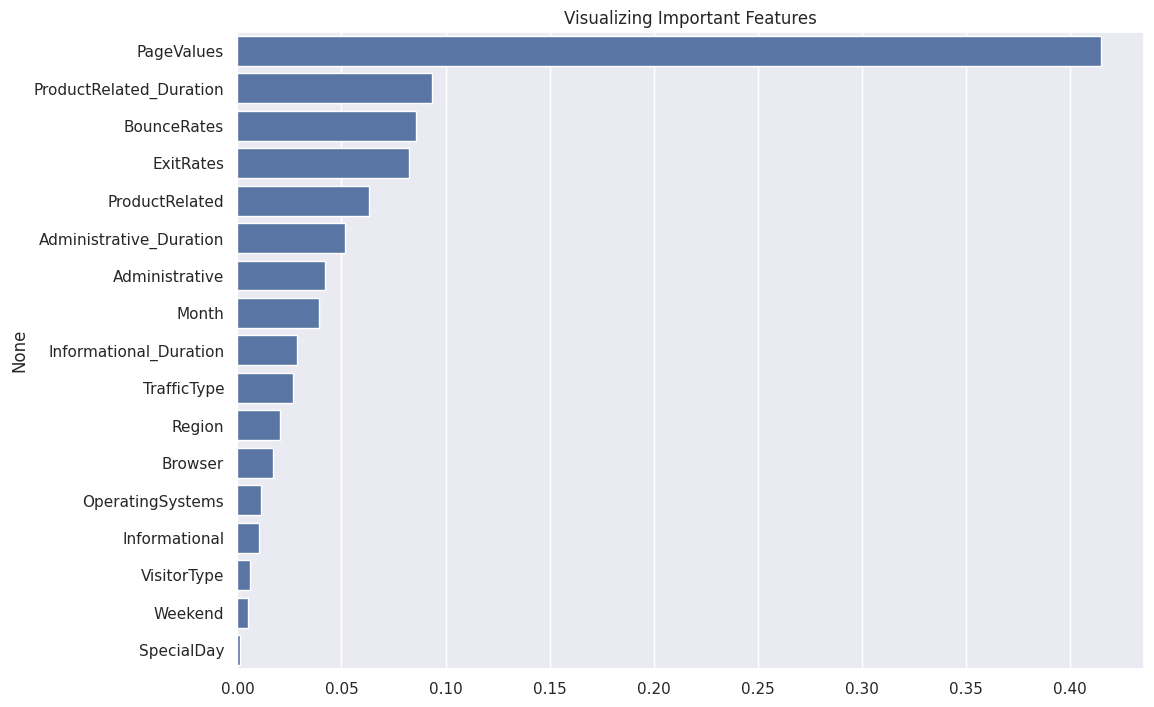

In [57]:
# Using decision tree classifier and obtaining the gini index
from sklearn.tree import DecisionTreeClassifier

# Assuming X_train and y_train are already defined

clf = DecisionTreeClassifier(criterion='gini')

# Fit the decision tree classifier
clf = clf.fit(X_train, y_train)
feature_importances = clf.feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
# Use X_train.columns to get feature names
sorted_feature_names = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a horizontal bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=sorted_importances, y=sorted_feature_names, orient='h')
plt.title("Visualizing Important Features")
plt.show()


Based on the gini index, we see that product related actions and the google analytics features (bounce and exit rates and page values) have more importance. We had already seen a similar result with the correlation heatmap. Now we have further solidified our hypothesis.

Below, we have the engineered features. We get rid of the unimportant features and we'll check if getting rid of them affects our results.

In [58]:
X_eng = df.copy()
X_eng.drop(X_eng.columns.difference(['PageValues','ProductRelated_Duration','ProductRelated','BounceRates','ExitRates']), axis=1, inplace=True)
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, y, test_size=0.2,random_state=42)
X_train_eng = scale(X_train_eng)
X_test_eng = scale(X_test_eng)

# Model Training


## Logistic Regression

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

       False       0.88      0.98      0.93      2055
        True       0.74      0.33      0.46       411

    accuracy                           0.87      2466
   macro avg       0.81      0.65      0.69      2466
weighted avg       0.86      0.87      0.85      2466



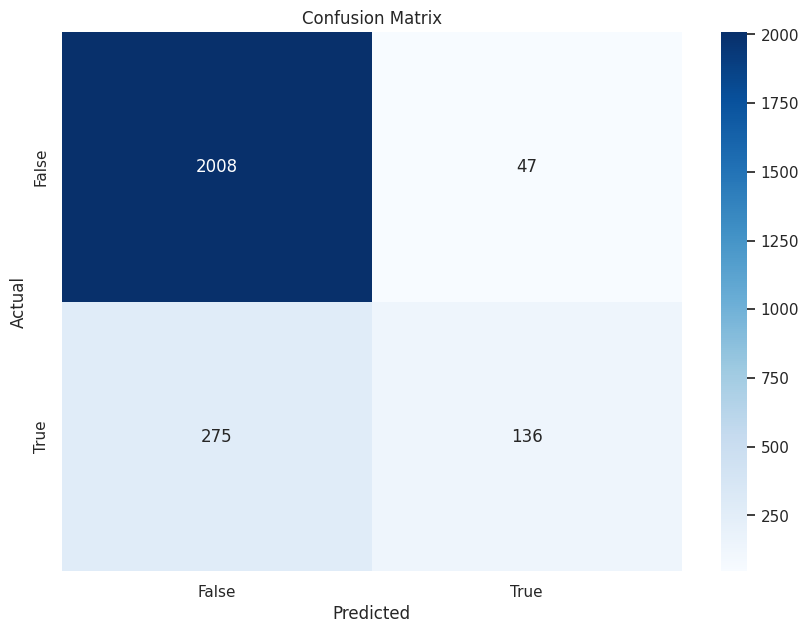

In [59]:
# Build Logistic Regression model with the SELECTED features
from sklearn.linear_model import LogisticRegression


mdlLgr = LogisticRegression(random_state=1)
mdlLgr.fit(X_train_eng, y_train_eng)
y_test_pred = mdlLgr.predict(X_test_eng)
print ('Classification Report (Logistic Regression):')
print (classification_report(y_test_eng, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(y)), yticklabels=list(set(y)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Although we have high accuracy, this doesn't mean our model is working as desired. High accuracy in unbalanced datasets is typical because the model classifies the data points as the majority class, which is why we get a lot of false negative values. Our models classify mostly as negative (false in our case). This results in a low recall value for the minority class.

In [60]:
# Build Logistic Regression model with ALL features
from sklearn.linear_model import LogisticRegression


mdlLgr = LogisticRegression(random_state=1)
mdlLgr.fit(X_train, y_train)
y_test_pred = mdlLgr.predict(X_test)
print ('Classification Report (Logistic Regression):')
print (classification_report(y_test, y_test_pred))

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

       False       0.88      0.98      0.93      2055
        True       0.73      0.34      0.46       411

    accuracy                           0.87      2466
   macro avg       0.81      0.66      0.69      2466
weighted avg       0.86      0.87      0.85      2466



We built a logistic regression model with selected and all features. We found that removing the insignificant features doesn't affect our results- in fact we get slightly better results when they're removed. We'll try new models with our engineered features.

## SVM

Classification Report (SVM):
              precision    recall  f1-score   support

       False       0.90      0.96      0.93      2055
        True       0.73      0.49      0.59       411

    accuracy                           0.88      2466
   macro avg       0.82      0.73      0.76      2466
weighted avg       0.87      0.88      0.87      2466



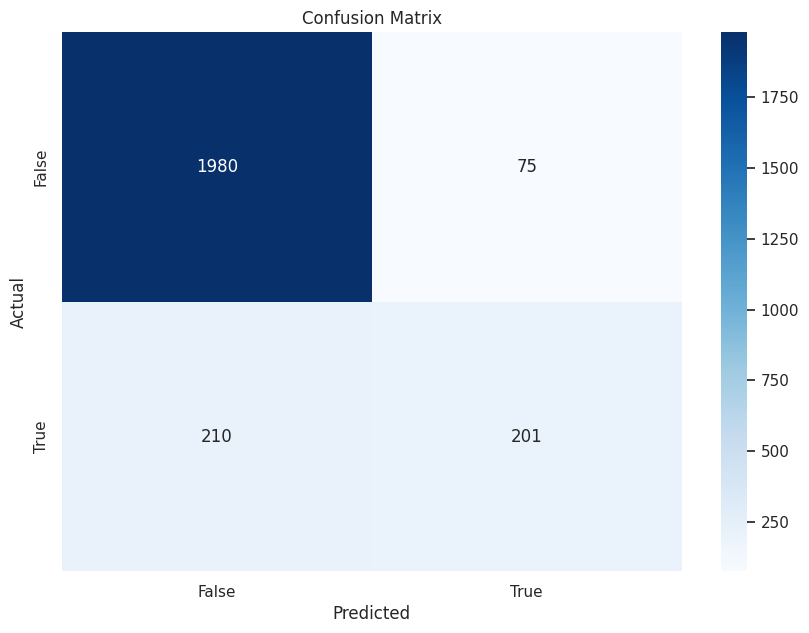

In [61]:
# Build SVM model with the SELECTED features
from sklearn.svm import SVC


mdlSvm = SVC(random_state=42,probability=True)
mdlSvm.fit(X_train_eng, y_train_eng)
y_test_pred = mdlSvm.predict(X_test_eng)
print ('Classification Report (SVM):')
print (classification_report(y_test_eng, y_test_pred))
cm = confusion_matrix(y_test_eng, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(y)), yticklabels=list(set(y)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

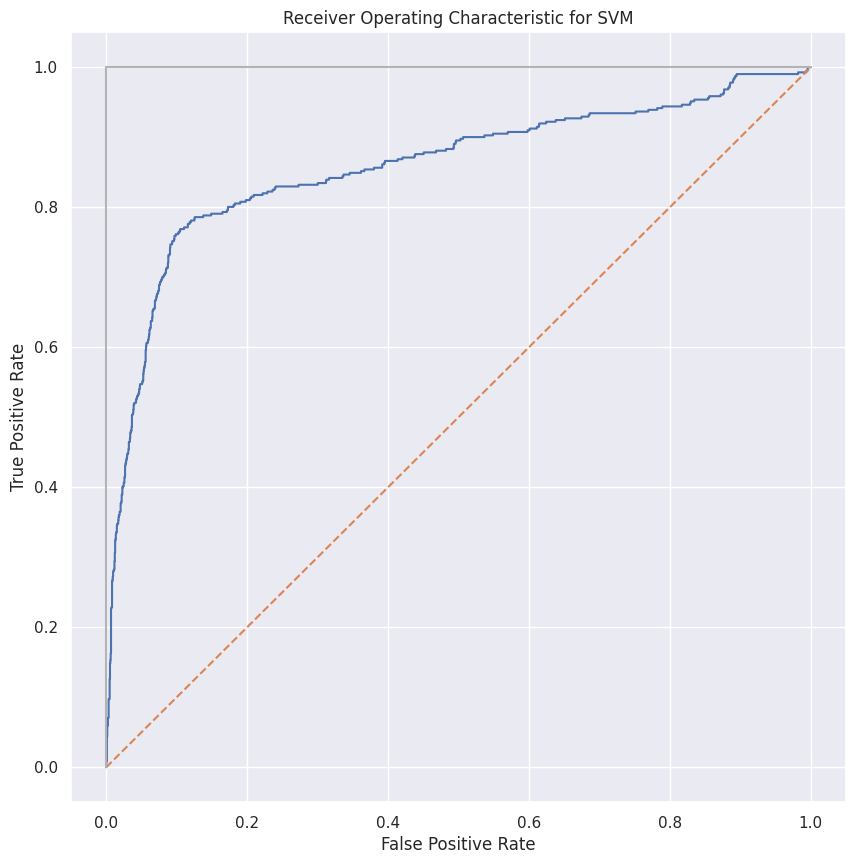

AUC: 0.8580158772443924


In [62]:
y_score = mdlSvm.predict_proba(X_test_eng)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_eng, y_score)
roc_auc = roc_auc_score(y_test_eng, y_score)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic for SVM')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC: ' + str(roc_auc))

Classification Report (SVM):
              precision    recall  f1-score   support

       False       0.90      0.97      0.93      2055
        True       0.74      0.44      0.55       411

    accuracy                           0.88      2466
   macro avg       0.82      0.70      0.74      2466
weighted avg       0.87      0.88      0.87      2466



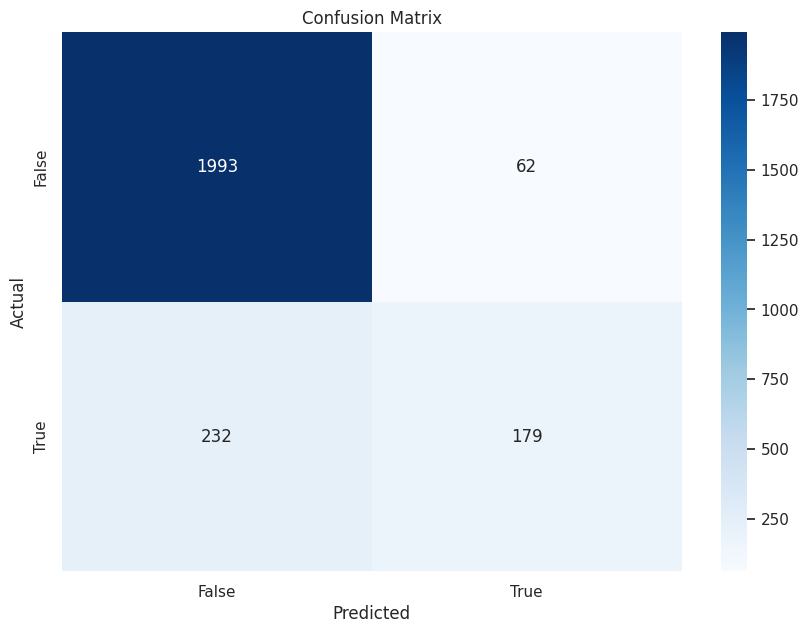

In [63]:
# Build SVM model with ALL features
from sklearn.svm import SVC


mdlSvm = SVC(random_state=42)
mdlSvm.fit(X_train, y_train)
y_test_pred = mdlSvm.predict(X_test)
print ('Classification Report (SVM):')
print (classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(y)), yticklabels=list(set(y)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We saw that SVM performs better with feature engineering as well (AUC of 85%). It also performs better than logistic regression. However, ROC curve could get better as well as the minority class classification rates.

## XGBoost
Next, we'll analyze decision tree ensemble learning algorithms XGBoost and Random Forest. First, we'll analyze XGBoost's result. Since XGBoost already decides on the important features itself, we'll feed all features to it.

Classification Report (XGBoost):
              precision    recall  f1-score   support

       False       0.91      0.94      0.93      2055
        True       0.65      0.56      0.60       411

    accuracy                           0.88      2466
   macro avg       0.78      0.75      0.76      2466
weighted avg       0.87      0.88      0.87      2466



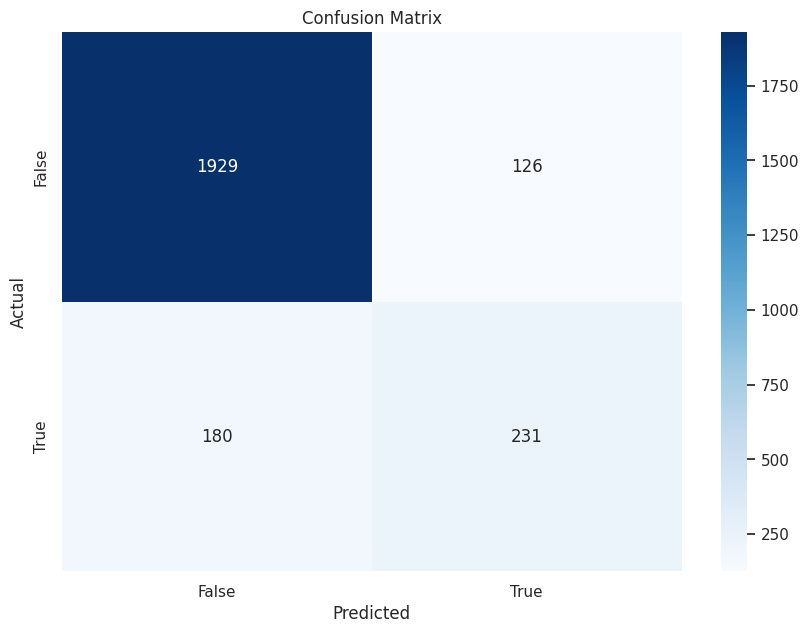

In [64]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)
y_test_pred = xgb_clf.predict(X_test)
print ('Classification Report (XGBoost):')
print (classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(y)), yticklabels=list(set(y)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

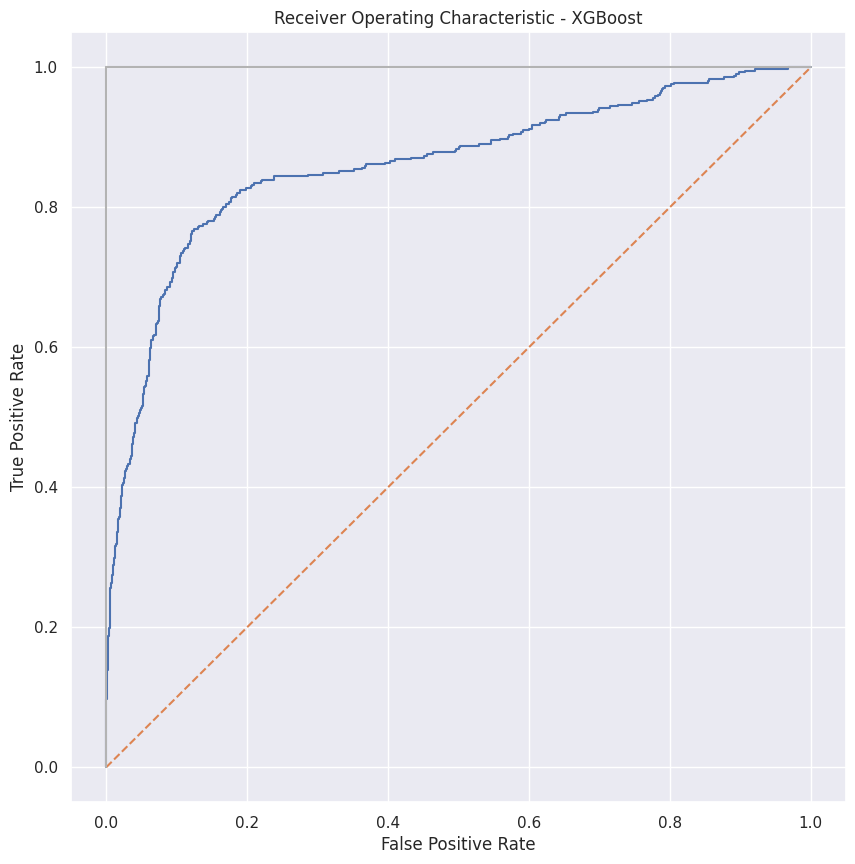

AUC: 0.8613032127444189


In [65]:

y_score = xgb_clf.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC: ' + str(roc_auc))

In [66]:
thresholds = np.sort(xgb_clf.feature_importances_)

In [67]:
for thresh in thresholds:
 # select features using threshold
 selection = SelectFromModel(xgb_clf, threshold=thresh, prefit=True)
 select_X_train = selection.transform(X_train)
 # train model
 selection_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
 selection_model.fit(select_X_train, y_train)
 # eval model
 select_X_test = selection.transform(X_test)
 predictions = selection_model.predict(select_X_test)
 accuracy = accuracy_score(y_test, predictions)
 print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.029, n=17, Accuracy: 88.48%
Thresh=0.030, n=16, Accuracy: 87.83%
Thresh=0.031, n=15, Accuracy: 87.96%
Thresh=0.032, n=14, Accuracy: 88.16%
Thresh=0.032, n=13, Accuracy: 87.83%
Thresh=0.033, n=12, Accuracy: 88.00%
Thresh=0.034, n=11, Accuracy: 88.16%
Thresh=0.034, n=10, Accuracy: 88.08%
Thresh=0.034, n=9, Accuracy: 87.83%
Thresh=0.034, n=8, Accuracy: 88.40%
Thresh=0.037, n=7, Accuracy: 87.92%
Thresh=0.038, n=6, Accuracy: 88.00%
Thresh=0.043, n=5, Accuracy: 88.04%
Thresh=0.048, n=4, Accuracy: 87.79%
Thresh=0.068, n=3, Accuracy: 87.92%
Thresh=0.096, n=2, Accuracy: 86.78%
Thresh=0.348, n=1, Accuracy: 87.83%


We got 88% accuracy, 86% AUC and 56% recall for "true" class with XGBoost.

# Random Forest
Since random forest uses "bagging" method, we're expecting to see a less overfitted model.

Classification Report (Random Forest):
              precision    recall  f1-score   support

       False       0.91      0.96      0.94      2055
        True       0.76      0.55      0.63       411

    accuracy                           0.89      2466
   macro avg       0.84      0.75      0.79      2466
weighted avg       0.89      0.89      0.89      2466



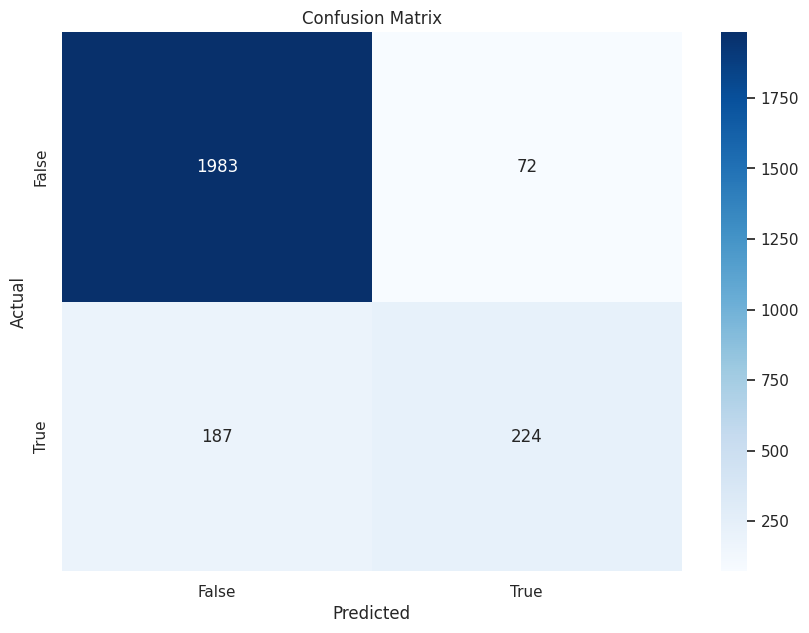

In [68]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print ('Classification Report (Random Forest):')
print (classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(y)), yticklabels=list(set(y)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


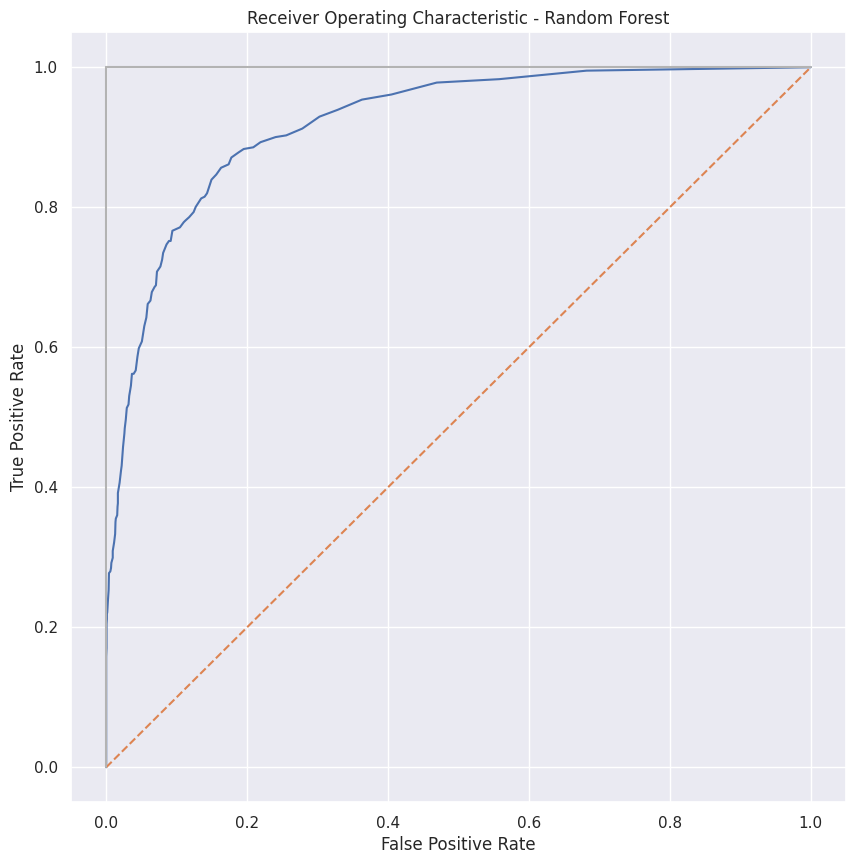

AUC: 0.9197394048105327


In [69]:
y_score = rf.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC: ' + str(roc_auc))

We obtain approximately 90% accuracy for both XGBoost and Random Forest. We fed all features to both of these models because feeding the engineered features did not yield a different result. Both of these models have 0.9 AUC score (although in this random state XGBoost has 86% and RandomForest 91%, there were many random instances where they were 90%. Which is why I'm saying approximately 90%), which is a satisfactory score. The recall value for bot of these models are 56% and 55% respectively, which is the best we have obtained.

## Discussing the results
Even though we dropped certain features because they were not important, we trained our models with both sets of features- the selected features and all features. In most cases the results did not show a stark contrast. When we analyzed the feature importance for the XGBoost model, we saw that although as the number of features decreased, the accuracy decreased; the decrease was not steep. We obtain similar accuracies regardless of the number of features. What changed throughout the models were the classificiton of the minority class, which improved throughout the models with XGBoost and Random forest yielding the best results in terms of FPR/TPR ratio and minority class recall.

# Model Optimization
We'll do hyper parameter tuning and cross validation for XGBoost and Random Forest in this section, because they were the best performing models from the previous section. For hyper parameter tuning, we'll start with GridSearch, which performs an exhaustive search over a grid of hyperparameters. We'll do this to obtain the optimal combination. The function GridSearchCV also has a built in cross validation option, which was our next step.

## XGBoost

In [70]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
Best score:  0.9053126436096225


Let's obtain the performance metrics and the ROC curve for the tuned model and cross validate afterwards.

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2193
           1       0.81      0.88      0.85       273

    accuracy                           0.96      2466
   macro avg       0.90      0.93      0.91      2466
weighted avg       0.97      0.96      0.97      2466



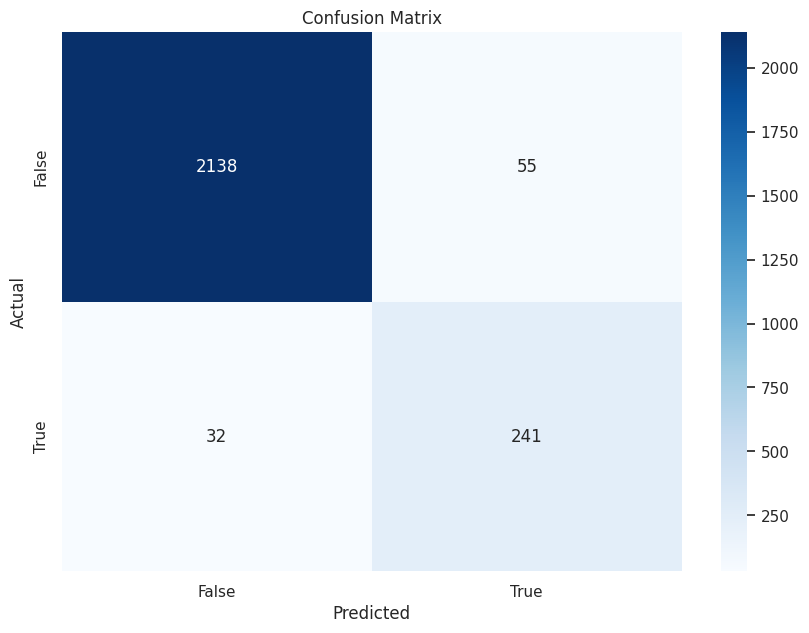

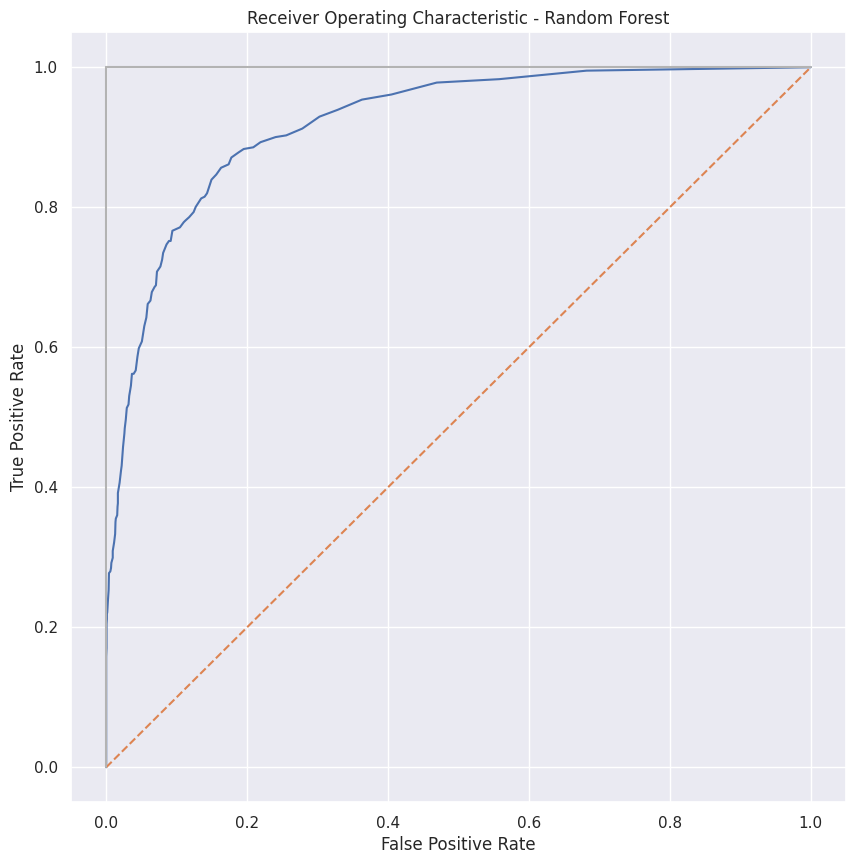

AUC: 0.9197394048105327


In [71]:
xgb_clf = XGBClassifier(learning_rate=0.01,max_depth=7,n_estimators=200,subsample=0.7,random_state=42)
xgb_clf.fit(X_train, y_train)
y_test_pred = xgb_clf.predict(X_test)
print ('Classification Report (Random Forest):')
print (classification_report(y_test_pred, y_pred))
cm = confusion_matrix(y_test_pred, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(y)), yticklabels=list(set(y)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
y_score = rf.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC: ' + str(roc_auc))

Hyper-parameter tuned XGBoost model is yielding the best results overall: high "true" class recall of 88%, 97% accuracy and an AUC score of 92%. The ROC curve is near optimal, and the confusion matrix is dense in the diagonals.

In [72]:
cross_val_score(xgb_clf, scale(X), y, cv=5)

array([0.92214112, 0.90875912, 0.89416058, 0.88199513, 0.88807786])

We're getting some variance among cross validation scores, which means there is some level of overfitting, although not alarming. Let's repeat the procedure for Random Forest.

## Random Forest

In [73]:
%%time
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42)
# Fit the random search model
rf_random.fit(X_train, y_train)
best_random_estimator = rf_random.best_estimator_
random_rf_accuracy = accuracy_score(y_test,best_random_estimator.predict(X_test))
print('Best hyper parameters:',rf_random.best_params_)
rf_accuracy = accuracy_score(y_test,rf.predict(X_test))
print("Original Model's Accuracy score:",rf_accuracy)
print("Tuned Model's Accuracy score:",random_rf_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning:

The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.



Best hyper parameters: {'n_estimators': 200, 'max_depth': 10}
Original Model's Accuracy score: 0.8949716139497161
Tuned Model's Accuracy score: 0.8941605839416058
CPU times: user 2min 30s, sys: 386 ms, total: 2min 30s
Wall time: 2min 56s


In [74]:
cross_val_score(rf, scale(X), y, cv=5)

array([0.91930251, 0.90064882, 0.89537713, 0.88199513, 0.88361719])

Classification Report (Random Forest):
              precision    recall  f1-score   support

       False       0.91      0.97      0.94      2055
        True       0.76      0.54      0.63       411

    accuracy                           0.89      2466
   macro avg       0.84      0.75      0.78      2466
weighted avg       0.89      0.89      0.89      2466



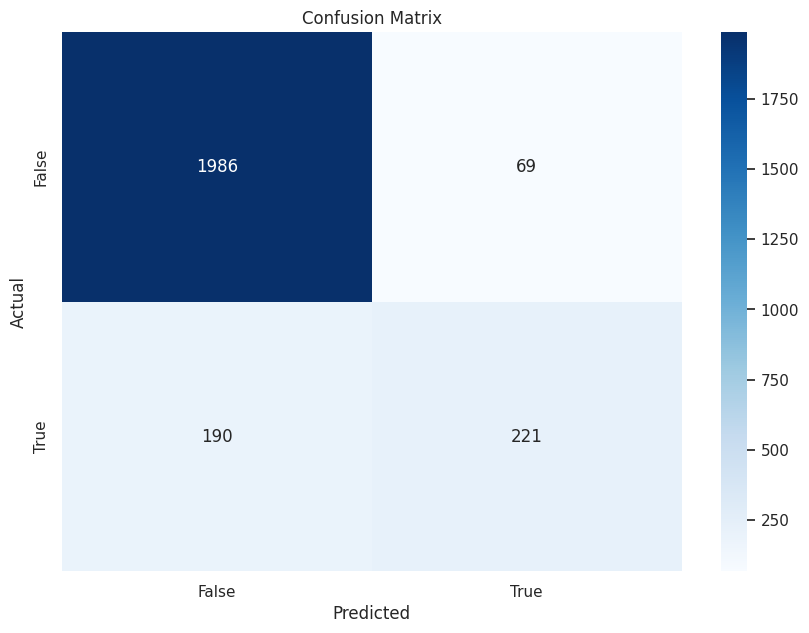

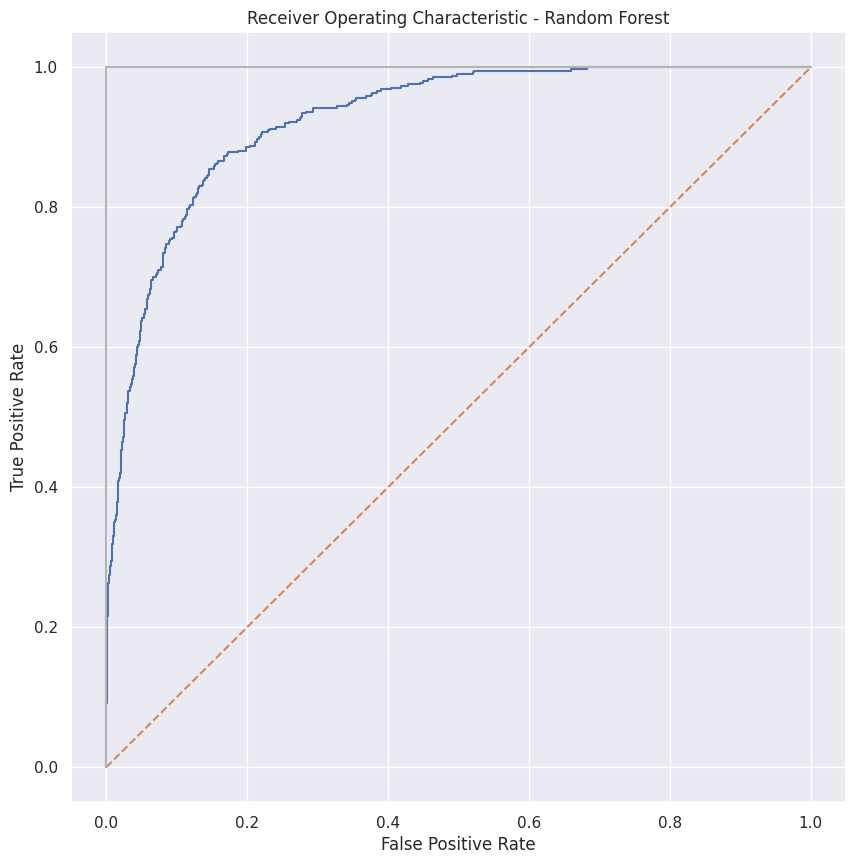

AUC: 0.9262258688972952


In [75]:
rf = RandomForestClassifier(n_estimators= 300, max_depth= 10,random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print ('Classification Report (Random Forest):')
print (classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(y)), yticklabels=list(set(y)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
y_score = rf.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC: ' + str(roc_auc))

Random Forest has gotten saturated at 90% accuracy and AUC score, even when we perform hyperparameter tuning, we're not getting better results. We got our best results with hyper-parameter tuned XGBoost.

# Conclusion
* We started with EDA. We saw that our dataset was unbalanced, with the majority conspiring of no purchase. After that, we set out to find features that may be related to revenue. We looked at month, specialday, other technical features like Browser type etc. We then analyzed the relationship between ProductRelated, Administrative and Informational pages and their durations. Then we seperated these last 3 mentioned features by their revenue value. To make a fair comparison; when using the histogram method, we took the average. We found that side by side, they seemed like duplicates of each other. So at first glance, we couldn't capture any relation between revenue and the mentioned features. We also found that bounce and exit rates were positively correlated but still, these two features didn't seem to change that much based on revenue. When we looked at PageValues we finally saw a distinction between revenue=True and revenue=False.
* We're aware that analyzing the features one by one to find correlation may be misleading, as the relations may not be apparent at first sight. So we looked at the correlation heatmap including all features. We found that PageValues, ProductRelated features were positively correlated with revenue, while bound and exit rates were negatively correlated. We also looked at the gini index to find out the important features and found a similar result.
* We moved onto preprocessing, where we label encoded the categorical features, scaled all features and split our data to train and test sets with training having the 80% of data.
* We dropped the insignificant features. We still had the feature set containing all features. We compared the two for all models.
* We proceeded with model training. We started with logistic regression but logistic regression was struggling to predict the minority class, who have made a purchase.
* We proceeded with SVM, which gave more satisfactory results. It was better at predicting the minority class, but we were still suspecting some overfitting and the ROC curve was not yet looking ideal. With SVM, the engineered features were working better.
* Since decision tree classifiers like XGBoost and Random Forest use multiple models before reaching a conclusion, we tried them one by one. Both resulted in near 90% accuracy and 90% AUC.
* We used Grid Search and Randomized Search for hyperparameter tuning for XGBoost and Random Forest respectively. Grid Search for XGBoost resulted in nearly ideal parameters- with minority class recall being 88%, accuracy 97% and AUC 92%. Randomized Search increased Random Forest's accuracy by 1%, resulted in 60% recall for the minority class, and a 93% AUC score.
* In the end, we got our best result with hyper parameter tuned XGBoost model. Our model can now predict the minority class accurately.
### Analysis
Since our dataset was unbalanced, the models we tried were overfitting the data. Even though we were getting high accuracy, accuracy was not a reliable metric for us. We tried to combat this result by trying different models that are better at handling overfitting and gradually achieved better results. Our recall for the minority class was around 40% when we started and 88% with the tuned Random Forest model, which was the last model we tried. We overcame the overfitting obstacle through hyper parameter tuning.
### Insights
Visitors who visit a lot of pages before completing a transaction are more intentional about making a purchase. Users who bounce are less intentional. Also, users who look at product related pages are more intentional as well. Therefore, trying to reach customers who visit a lot of related or non related pages makes more sense, as they are the customers that will likely make a purchase.
### Limitations and Potential Improvements
Performing hyperparameter tuning with lots of different variables requires a lot of computational power. Even though I wanted to explore more possibilites, I faced computational limitations. Maybe exploring more hyper-parameters could yield better results, even though the results we already obtained are more than we could hope for. Also, I think in some ways the way this data was collected is limiting as well. For example I thought there should be a correlation between SpecialDay and purchase, but the way SpecialDay was calculated, it seemed like there were only special days in May and February. January and April data was non existent for example.
I also think that minority class prediction may be improved with methods other than hyper parameter tuning, like feature engineering.



